In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline


from bs4 import BeautifulSoup
import requests
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

import pandas as pd


In [240]:
def get_data(week_nums):
    url = 'https://www.baseball-reference.com/teams/NYY/{}.shtml'
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        df = pd.read_html(file_url)[0]
        df['YEAR'] = week_num
        dfs.append(df)
        
    return pd.concat(dfs)
        
week_nums = range(1960,2019)
yankees_df = get_data(week_nums)

In [241]:
yankees_df.reset_index(inplace= True, drop = True)
mask_1 = yankees_df['Age'] != 'Age'


In [242]:
yankees_df = yankees_df[mask_1]

In [243]:
mask_2 = yankees_df.Rk.isna()

In [244]:
yankees_df = yankees_df[~mask_2]

In [247]:
yankees_df.Pos.value_counts()

P     1149
C      185
OF     131
DH     128
1B     127
3B     116
LF     110
SS     106
RF     101
2B      96
CF      85
IF      70
UT      61
MI      20
CI       9
Name: Pos, dtype: int64

In [249]:
yankees_df.shape

(2504, 29)

In [250]:
yankees_df = yankees_df[yankees_df['Pos'] != 'P']

In [251]:
yankees_df.shape

(1355, 29)

In [252]:

yankees_df[['Age','G','PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG','OPS','OPS+',
                 'TB','GDP','HBP','SH','SF','IBB']] = yankees_df[['Age','G','PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG','OPS','OPS+',
                 'TB','GDP','HBP','SH','SF','IBB']].apply(pd.to_numeric)


/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [253]:
yankees_df.rename(columns={'2B':'D','3B':'T'},inplace= True)

/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [254]:
yankees_df_train = yankees_df.sort_values(['Name','YEAR'])

In [255]:
yankees_df_train['HR_PREDICT'] = yankees_df_train.groupby(['Name']).HR.shift(-1).to_list()

In [256]:
yankees_df_train[['Name','YEAR','HR','HR_PREDICT']]

,Name,YEAR,HR,HR_PREDICT
1973,Aaron Boone,2003,6,NaN
2142,Aaron Guiel*,2006,4,NaN
2703,Aaron Hicks#,2016,8,15.0
2766,Aaron Hicks#,2017,15,27.0
2819,Aaron Hicks#,2018,27,NaN
...,...,...,...,...
97,Yogi Berra*,1962,10,8.0
139,Yogi Berra*,1963,8,NaN
2587,Zelous Wheeler,2014,2,NaN
2522,Zoilo Almonte#,2013,1,1.0


In [257]:
yankees_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355 entries, 1973 to 2588
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          1355 non-null   object 
 1   Pos         1345 non-null   object 
 2   Name        1355 non-null   object 
 3   Age         1355 non-null   int64  
 4   G           1355 non-null   int64  
 5   PA          1355 non-null   int64  
 6   AB          1355 non-null   int64  
 7   R           1355 non-null   int64  
 8   H           1355 non-null   int64  
 9   D           1355 non-null   int64  
 10  T           1355 non-null   int64  
 11  HR          1355 non-null   int64  
 12  RBI         1355 non-null   int64  
 13  SB          1355 non-null   int64  
 14  CS          1355 non-null   int64  
 15  BB          1355 non-null   int64  
 16  SO          1355 non-null   int64  
 17  BA          1343 non-null   float64
 18  OBP         1343 non-null   float64
 19  SLG         1343 non-nul

In [260]:
yankees_df_train[yankees_df_train.Pos.isnull()]

,Rk,Pos,Name,Age,G,PA,AB,R,H,D,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,YEAR,HR_PREDICT
316,24,NaN,Charlie Sands*,19,1,1,1,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1967,NaN
1270,23,NaN,Chris Chambliss*,39,1,1,1,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1988,NaN
793,20,NaN,Dell Alston*,25,3,3,3,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1978,NaN
526,18,NaN,Frank Tepedino*,24,8,8,8,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1972,NaN
2656,23,NaN,Gary Sanchez,22,2,2,2,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,2015,20.0
60,16,NaN,Jesse Gonder*,25,15,15,12,2,4,1,...,0.883,144.0,5,1,0,0,0,1,1961,NaN
1221,27,NaN,Keith Hughes*,23,4,4,4,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1987,NaN
64,20,NaN,Lee Thomas*,25,2,2,2,0,1,0,...,1.000,175.0,1,0,0,0,0,0,1961,NaN
403,24,NaN,Nate Oliver,28,1,1,1,0,0,0,...,0.000,-100.0,0,0,0,0,0,0,1969,NaN
226,24,NaN,Pedro Gonzalez,27,7,6,5,0,2,1,...,1.000,182.0,3,0,0,1,0,0,1965,NaN


# all of the seasons that is cleaned, grouped, sorted. Y hat is HR_Predict. etc.
yankess_pinstripes_clean = yankees_df_train.dropna()
yankess_pinstripes_clean.shape

In [261]:
yankess_pinstripes_clean = yankees_df_train[~yankees_df_train.HR_PREDICT.isna()]

In [262]:
yankess_pinstripes_clean.shape

(818, 30)

In [265]:
yankess_pinstripes_clean.Pos.isnull().sum()

1

In [274]:
yankess_pinstripes_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 2703 to 2522
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          816 non-null    object 
 1   Pos         816 non-null    object 
 2   Name        816 non-null    object 
 3   Age         816 non-null    int64  
 4   G           816 non-null    int64  
 5   PA          816 non-null    int64  
 6   AB          816 non-null    int64  
 7   R           816 non-null    int64  
 8   H           816 non-null    int64  
 9   D           816 non-null    int64  
 10  T           816 non-null    int64  
 11  HR          816 non-null    int64  
 12  RBI         816 non-null    int64  
 13  SB          816 non-null    int64  
 14  CS          816 non-null    int64  
 15  BB          816 non-null    int64  
 16  SO          816 non-null    int64  
 17  BA          816 non-null    float64
 18  OBP         816 non-null    float64
 19  SLG         816 non-null 

In [270]:
yankess_pinstripes_clean[yankess_pinstripes_clean.isnull().any(axis = 1)]

,Rk,Pos,Name,Age,G,PA,AB,R,H,D,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,YEAR,HR_PREDICT
105,18,3B,Jake Gibbs*,23,2,0,0,2,0,0,...,NaN,NaN,0,0,0,0,0,0,1962,0.0
1596,22,C,Jorge Posada#,23,1,0,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,1995,0.0


In [269]:
yankess_pinstripes_clean.loc[yankess_pinstripes_clean.Name == 'Gary Sanchez','Pos'] = "C"

/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [273]:
yankess_pinstripes_clean.dropna(inplace = True)

/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


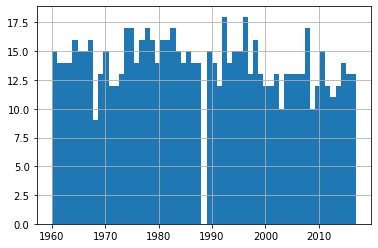

In [276]:
yankess_pinstripes_clean.YEAR.hist(bins = 59)

In [277]:
pinstripes_clean_tr = yankess_pinstripes_clean[yankess_pinstripes_clean.YEAR<(2007)]

In [278]:
pinstripes_clean_tr.shape

(674, 30)

In [288]:
# Very important!!!!! set year for how many season to withold. come up with obvious name
pinstripes_clean_test = yankess_pinstripes_clean[yankess_pinstripes_clean.YEAR >=(2007)] # test 

In [289]:
pinstripes_clean_test.shape

(142, 30)

In [290]:
pd.DataFrame(pinstripes_clean_test.YEAR.value_counts()).sort_index()

,YEAR
2007,13
2008,17
2009,10
2010,12
2011,15
2012,12
2013,11
2014,12
2015,14
2016,13


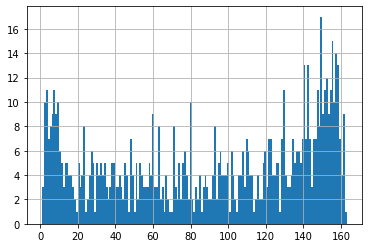

In [295]:
yankess_pinstripes_clean.G.hist(bins = yankess_pinstripes_clean.G.max())

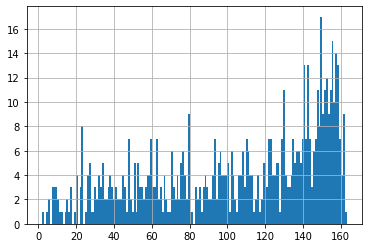

In [296]:
yankess_pinstripes_clean[yankess_pinstripes_clean.HR>0].G.hist(bins = yankess_pinstripes_clean.G.max())

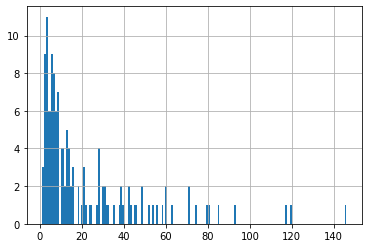

In [297]:
yankess_pinstripes_clean[yankess_pinstripes_clean.HR == 0].G.hist(bins = yankess_pinstripes_clean.G.max())

In [304]:
formula = 'HR_PREDICT ~ '
for col in pinstripes_clean_tr.columns[3:-1]:
    formula = formula + col + ' + '
formula[:-2]

'HR_PREDICT ~ Age + G + PA + AB + R + H + D + T + HR + RBI + SB + CS + BB + SO + BA + OBP + SLG + OPS + OPS+ + TB + GDP + HBP + SH + SF + IBB + YEAR '

In [306]:
# STATSMODEL
y, X = patsy.dmatrices('HR_PREDICT ~ Age + HR + G +PA + AB + R + H + D + T + RBI + BB + SO + GDP + SF + IBB+ SLG', 
                       pinstripes_clean_tr, return_type="dataframe")


model = sm.OLS(y, sm.add_constant(X))


fit = model.fit()


fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HR_PREDICT   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     57.38
Date:                Wed, 15 Jul 2020   Prob (F-statistic):          3.76e-113
Time:                        22:23:49   Log-Likelihood:                -2215.2
No. Observations:                 674   AIC:                             4464.
Df Residuals:                     657   BIC:                             4541.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5047      1.959      4.852      0.000       5.659      13.351
Age           -0.2664      0.070     -3.827      0.000      -0.403      -0.130
HR             0.5351      0.087      6.184      0.000       0.365       0.705
G             -0.0412      0.023     -1.789      0.074      -0.086       0.004
PA            -0.1193      0.071     -1.672      0.095      -0.259       0.021
AB             0.1164      0.072      1.621      0.106      -0.025       0.257
R             -0.0670      0.040     -1.687      0.092      -0.145       0.011
H              0.0388      0.038      1.027      0.305      -0.035       0.113
D              0.0593      0.067      0.886      0.376      -0.072       0.191
T              0.0410      0.171      0.239      0.811      -0.295       0.377
RBI            0.0960      0.039      2.441      0.015       0.019       0.173
BB             0.1589      0.073      2.173      0.030       0.015       0.302
SO             0.0235      0.015      1.522      0.129      -0.007       0.054
GDP            0.0266      0.075      0.354      0.724      -0.121       0.174
SF            -0.0278      0.158     -0.176      0.860      -0.337       0.282
IBB           -0.1564      0.115     -1.365      0.173      -0.381       0.069
SLG            0.7298      2.501      0.292      0.770      -4.180       5.640
==============================================================================
Omnibus:                      122.055   Durbin-Watson:                   2.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.923
Skew:                           0.960   Prob(JB):                     8.18e-63
Kurtosis:                       5.548   Cond. No.                     6.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [305]:
y, X = patsy.dmatrices(formula[:-2], 
                       pinstripes_clean_tr, return_type="dataframe")


model = sm.OLS(y, sm.add_constant(X))


fit = model.fit()


fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HR_PREDICT   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     38.10
Date:                Wed, 15 Jul 2020   Prob (F-statistic):          4.54e-107
Time:                        22:17:27   Log-Likelihood:                -2213.6
No. Observations:                 674   AIC:                             4477.
Df Residuals:                     649   BIC:                             4590.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6015     47.934     -0.013      0.990     -94.727      93.524
Age           -0.2791      0.072     -3.888      0.000      -0.420      -0.138
G             -0.0358      0.024     -1.507      0.132      -0.082       0.011
PA            -0.5581      0.688     -0.812      0.417      -1.909       0.792
AB             0.5554      0.688      0.808      0.420      -0.795       1.906
R             -0.0839      0.045     -1.884      0.060      -0.171       0.004
H             -0.0705      0.048     -1.456      0.146      -0.166       0.025
D             -0.0576      0.065     -0.882      0.378      -0.186       0.071
T             -0.1630      0.132     -1.231      0.219      -0.423       0.097
HR             0.1898      0.072      2.649      0.008       0.049       0.330
RBI            0.0934      0.041      2.293      0.022       0.013       0.173
SB             0.0352      0.047      0.743      0.458      -0.058       0.128
CS            -0.0417      0.136     -0.307      0.759      -0.309       0.225
BB             0.5891      0.686      0.858      0.391      -0.759       1.937
SO             0.0201      0.016      1.232      0.219      -0.012       0.052
BA            -6.5579     10.609     -0.618      0.537     -27.391      14.275
OBP          295.9438    504.257      0.587      0.557    -694.229    1286.117
SLG          291.1774    504.369      0.577      0.564    -699.214    1281.569
OPS         -290.0155    504.212     -0.575      0.565   -1280.100     700.069
TB             0.1152      0.033      3.460      0.001       0.050       0.181
GDP            0.0385      0.077      0.501      0.617      -0.112       0.189
HBP            0.5116      0.695      0.736      0.462      -0.853       1.876
SH             0.3596      0.689      0.522      0.602      -0.994       1.713
SF             0.4234      0.702      0.603      0.546      -0.954       1.801
IBB           -0.1487      0.116     -1.279      0.201      -0.377       0.080
YEAR           0.0051      0.024      0.209      0.834      -0.043       0.053
==============================================================================
Omnibus:                      118.922   Durbin-Watson:                   2.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.973
Skew:                           0.933   Prob(JB):                     5.89e-62
Kurtosis:                       5.561   Cond. No.                     1.00e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.81e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [357]:
lr = LinearRegression()

X_train = pinstripes_clean_tr[['Age','HR','G','PA','AB','R','H','D','T','RBI','BB','SO','GDP','SF','IBB']]
y_train = pinstripes_clean_tr['HR_PREDICT']

features = X_train.columns

lr.fit(X_train, y_train)
lr.score(X_train,y_train)

0.5828133294381268

In [358]:
lr.intercept_

9.686332047027092

In [359]:
list(zip(features,lr.coef_))

[('Age', -0.2643638642554821),
 ('HR', 0.5415455382266036),
 ('G', -0.04048953355089219),
 ('PA', -0.11950267364456756),
 ('AB', 0.11573673529447491),
 ('R', -0.06778308066920496),
 ('H', 0.041198382783817857),
 ('D', 0.06154138722315346),
 ('T', 0.046061049914378364),
 ('RBI', 0.095338296532912),
 ('BB', 0.15925654785038368),
 ('SO', 0.02345213619257974),
 ('GDP', 0.02625104516403777),
 ('SF', -0.027422504561916708),
 ('IBB', -0.1573058920662219)]

In [360]:
# First regression on test data ; lower  than the train data
X_test = pinstripes_clean_test[['Age','HR','G','PA','AB','R','H','D','T','RBI','BB','SO','GDP','SF','IBB']]
y_test = pinstripes_clean_test['HR_PREDICT']

lr.score(X_test,y_test)

0.4009154243818649

In [361]:
Y_hat = lr.predict(X_test)

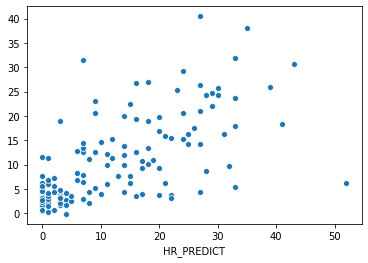

In [370]:
import seaborn as sns
sns.scatterplot(y_test,Y_hat)


In [371]:
resid = Y_hat-y_test
resid

2703    -7.255291
2766   -12.727902
2711   -45.756315
2763    13.477619
2201     2.825646
          ...    
2773    -3.524557
2772     2.467225
2195     0.800096
2248    11.543309
2522     3.221124
Name: HR_PREDICT, Length: 142, dtype: float64

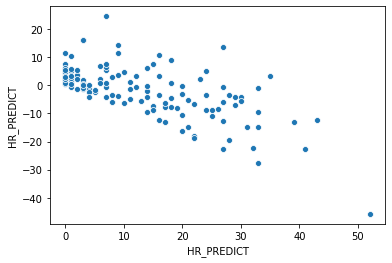

In [372]:
sns.scatterplot(y_test,resid)

In [352]:
# Standar Scalar. Making 
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
X_train = s.fit_transform(X_train)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train,y_train)

0.5828133294381268

In [353]:
lr.intercept_

9.114243323442134

In [354]:
list(zip(features,lr.coef_))

[('Age', -1.0960960427125095),
 ('HR', 5.53032705276018),
 ('G', -2.109034662813054),
 ('PA', -28.34498783087771),
 ('AB', 24.29119537434705),
 ('R', -2.34763765818416),
 ('H', 2.5327652183784366),
 ('D', 0.701485672087178),
 ('T', 0.09399358878440235),
 ('RBI', 3.2522550153256367),
 ('BB', 4.467199886980743),
 ('SO', 0.808301998068498),
 ('GDP', 0.1576510416369649),
 ('SF', -0.07637251112314064),
 ('IBB', -0.5369280095571085)]

In [168]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [172]:
m = LassoCV()
p = PolynomialFeatures(degree=2)
m.fit(p.fit_transform(scaled_X_train),y_train)
m.score(p.transform(scaled_X_train),y_train)

/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.425068564501998, tolerance: 6.099905917159765
  tol, rng, random, positive)
/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.226639786931628, tolerance: 6.099905917159765
  tol, rng, random, positive)
/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.382432641024934, tolerance: 6.099905917159765
  tol, rng, random, positive)
/Users/estebanzuniga/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_co

0.6296578416154311

In [173]:
X_test = pinstripes_clean_test[['Age','HR','G','PA','AB','R','H','D','T','RBI','BB','SO','GDP','SF','IBB']]
y_test = pinstripes_clean_test['HR_PREDICT']

lr.score(,y_test)

-52330.11935965578

In [373]:
from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures(degree=2)
x_train_poly = p.fit_transform(X_train)
lr.fit(x_train_poly,y_train)
lr.score(x_train_poly,y_train)

0.6798064528222951

In [374]:
lr.score(p.transform(X_test),y_test)

0.1948602278156425

Text(0.5, 1.0, 'Hits feature v Target ')

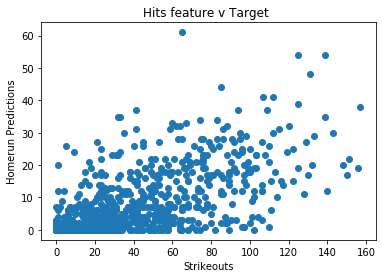

In [117]:
plt.scatter(pinstripes_clean_tr['SO'],y_train)
plt.xlabel('Strikeouts')
plt.ylabel('Homerun Predictions')
plt.title("Hits feature v Target ")



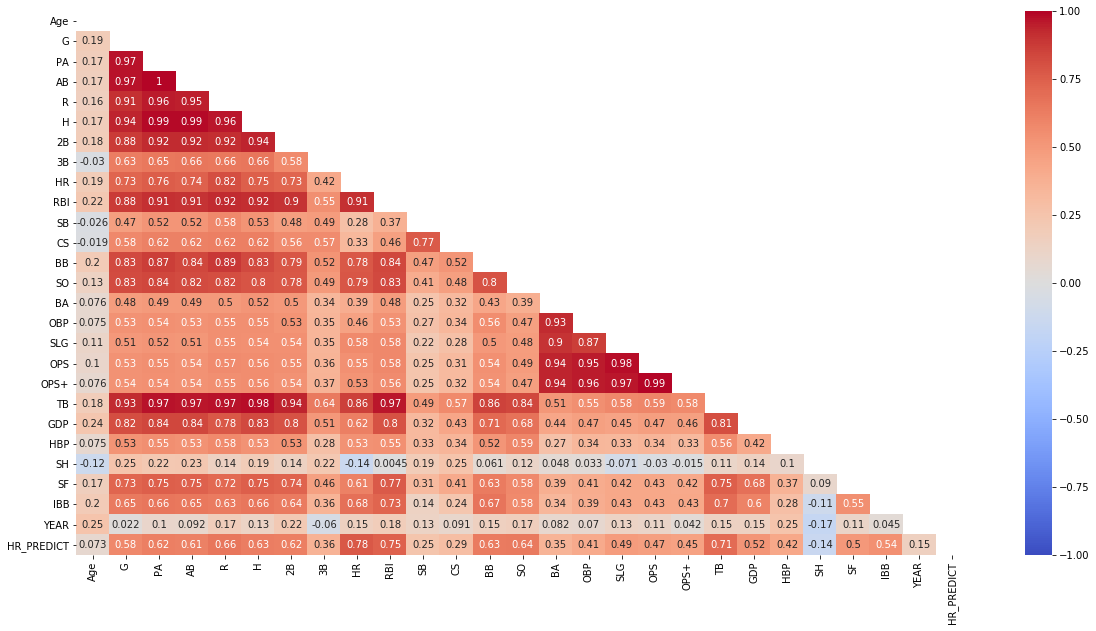

In [33]:
pincorr = pinstripes_clean_tr.corr()
mask_3 = np.zeros_like(pincorr, dtype=np.bool)
mask_3[np.triu_indices_from(mask_3)] = True


plt.figure(figsize=(20,10))
sns.heatmap(pinstripes_clean_tr.corr(),mask = mask_3, cmap="coolwarm", annot=True, vmin=-1, vmax=1);

In [2]:
# Bringing in Data via Web Scrapping
#url_2017 ='https://www.baseball-reference.com/teams/tgl.cgi?team=NYY&t=b&year=2017'

url_2010 = 'https://www.baseball-reference.com/teams/NYY/2010.shtml'
df_2010 = pd.read_html(url_2010)[0]

url_2011 = 'https://www.baseball-reference.com/teams/NYY/2011.shtml'
df_2011 = pd.read_html(url_2011)[0]

url_2012 = 'https://www.baseball-reference.com/teams/NYY/2012.shtml'
df_2012  = pd.read_html(url_2012)[0]

url_2013 = 'https://www.baseball-reference.com/teams/NYY/2013.shtml'
df_2013  = pd.read_html(url_2013)[0]

url_2014 = 'https://www.baseball-reference.com/teams/NYY/2014.shtml'
df_2014 = pd.read_html(url_2014)[0]

url_2015 = 'https://www.baseball-reference.com/teams/NYY/2015.shtml'
df_2015  = pd.read_html(url_2015)[0]
    
url_2016 = 'https://www.baseball-reference.com/teams/NYY/2016.shtml'
df_2016  = pd.read_html(url_2016)[0]

url_2017 = "https://www.baseball-reference.com/teams/NYY/2017.shtml" # Da Yankees
df_2017 = pd.read_html(url_2017)[0]

url_2018 = "https://www.baseball-reference.com/teams/NYY/2018.shtml"
df_2018 = pd.read_html(url_2018)[0]

url_2019 = "https://www.baseball-reference.com/teams/NYY/2019.shtml"
df_2019 = pd.read_html(url_2019)[0]


In [3]:
df_2010.drop('Rk',axis = 1, inplace = True)
df_2010.drop([9],inplace = True)
df_2010['YEAR'] = ('2010')
clean_df_2010 = (df_2010[df_2010.index < 23])

In [4]:
df_2011.drop('Rk',axis = 1, inplace = True)
df_2011.drop([9],inplace = True)
df_2011['YEAR'] = ('2011')
clean_df_2011 = (df_2011[df_2011.index < 21])

In [5]:
df_2012.drop('Rk',axis = 1, inplace = True)
df_2012.drop([9],inplace = True)
df_2012['YEAR'] = ('2012')
clean_df_2012 = (df_2012[df_2012.index < 24])

In [6]:
df_2013.drop('Rk',axis = 1, inplace = True)
df_2013.drop([9],inplace = True)
df_2013['YEAR'] = ('2013')
clean_df_2013 = (df_2013[df_2013.index < 34])

In [7]:
df_2014.drop('Rk',axis = 1, inplace = True)
df_2014.drop([9],inplace = True)
df_2014['YEAR'] = ('2014')
clean_df_2014 = (df_2014[df_2014.index < 27])

In [8]:
df_2015.drop('Rk',axis = 1, inplace = True)
df_2015.drop([9],inplace = True)
df_2015['YEAR'] = ('2015')
clean_df_2015 = (df_2015[df_2015.index < 26])

In [9]:
#  clean 2016dropped 'Rk' Column inplace true and 9th row because it was another column header. reduced to just batters added column for year visual
df_2016.drop('Rk',axis = 1, inplace = True)
df_2016.drop([9],inplace = True)
df_2016["YEAR"] =('2016')
clean_df_2016 = (df_2016[df_2016.index < 25])




In [10]:
# CLEAN 2017 same as 2016 dropped 'rk' and 9th row
df_2017.drop('Rk', axis = 1, inplace = True)
df_2017.drop([9], inplace = True)
df_2017['YEAR'] = ('2017')
clean_df_2017 = (df_2017[df_2017.index < 25])



In [11]:
# In place in true on dropping row 9. dropped col 'Rk'
df_2018.drop('Rk', axis = 1 , inplace = True)
df_2018.drop([9], inplace = True)
df_2018['YEAR'] = ('2018')
clean_df_2018 = (df_2018[df_2018.index < 24])



In [12]:
df_2019.drop('Rk',axis = 1, inplace = True)
df_2019.drop([9],inplace = True)
df_2019['YEAR'] = ('2019')
clean_df_2019 = (df_2019[df_2019.index < 25])



In [41]:
#don't forget that 2019 is out
clean_seasons = [clean_df_2010,clean_df_2011,clean_df_2012,clean_df_2013,clean_df_2014,clean_df_2015,clean_df_2016,clean_df_2017,clean_df_2018,clean_df_2019]

val_seasons= [clean_df_2018,clean_df_2019]

seasons_combined_train = pd.concat(clean_seasons)

seasons_combined_val = pd.concat(val_seasons)


seasons_combined_train[['Age','G','PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG','OPS','OPS+',
                 'TB','GDP','HBP','SH','SF','IBB']] = seasons_combined_train[['Age','G','PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG','OPS','OPS+',
                 'TB','GDP','HBP','SH','SF','IBB']].apply(pd.to_numeric)




seasons_combined_val[['Age','G','PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG','OPS','OPS+',
                 'TB','GDP','HBP','SH','SF','IBB']] = seasons_combined_val[['Age','G','PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG','OPS','OPS+',
                 'TB','GDP','HBP','SH','SF','IBB']].apply(pd.to_numeric)


seasons_combined_train.drop('CS',axis = 1, inplace = True)
seasons_combined_val.drop('CS',axis = 1, inplace = True)




In [18]:
seasons_combined_train.drop(['Pos','Age','SH','BA','3B','OBP','SB','SLG','OPS','TB','OPS+'], axis = 1, inplace = True)

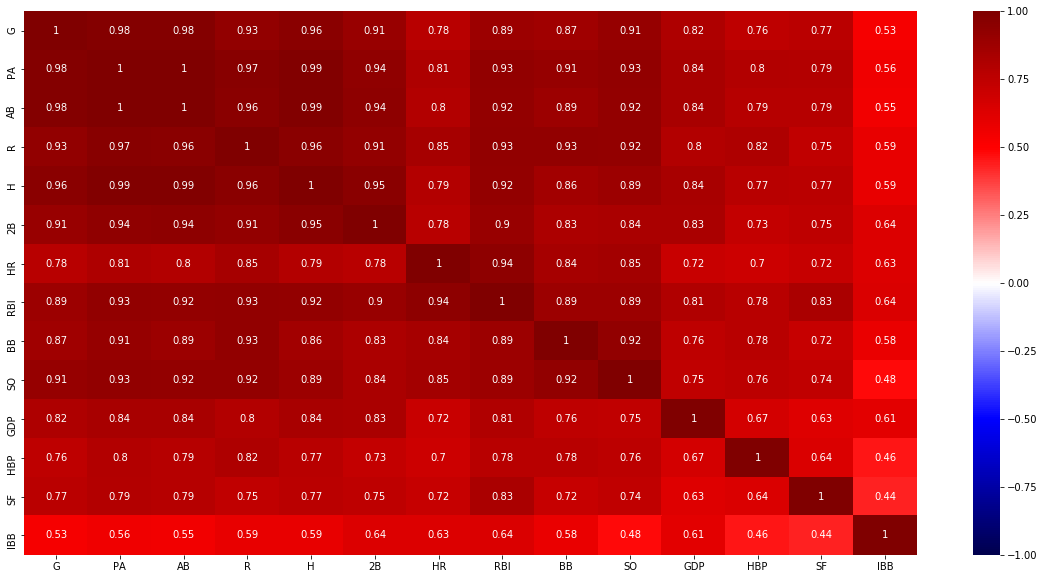

In [19]:
plt.figure(figsize =(20,10))
sns.heatmap(seasons_combined_train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

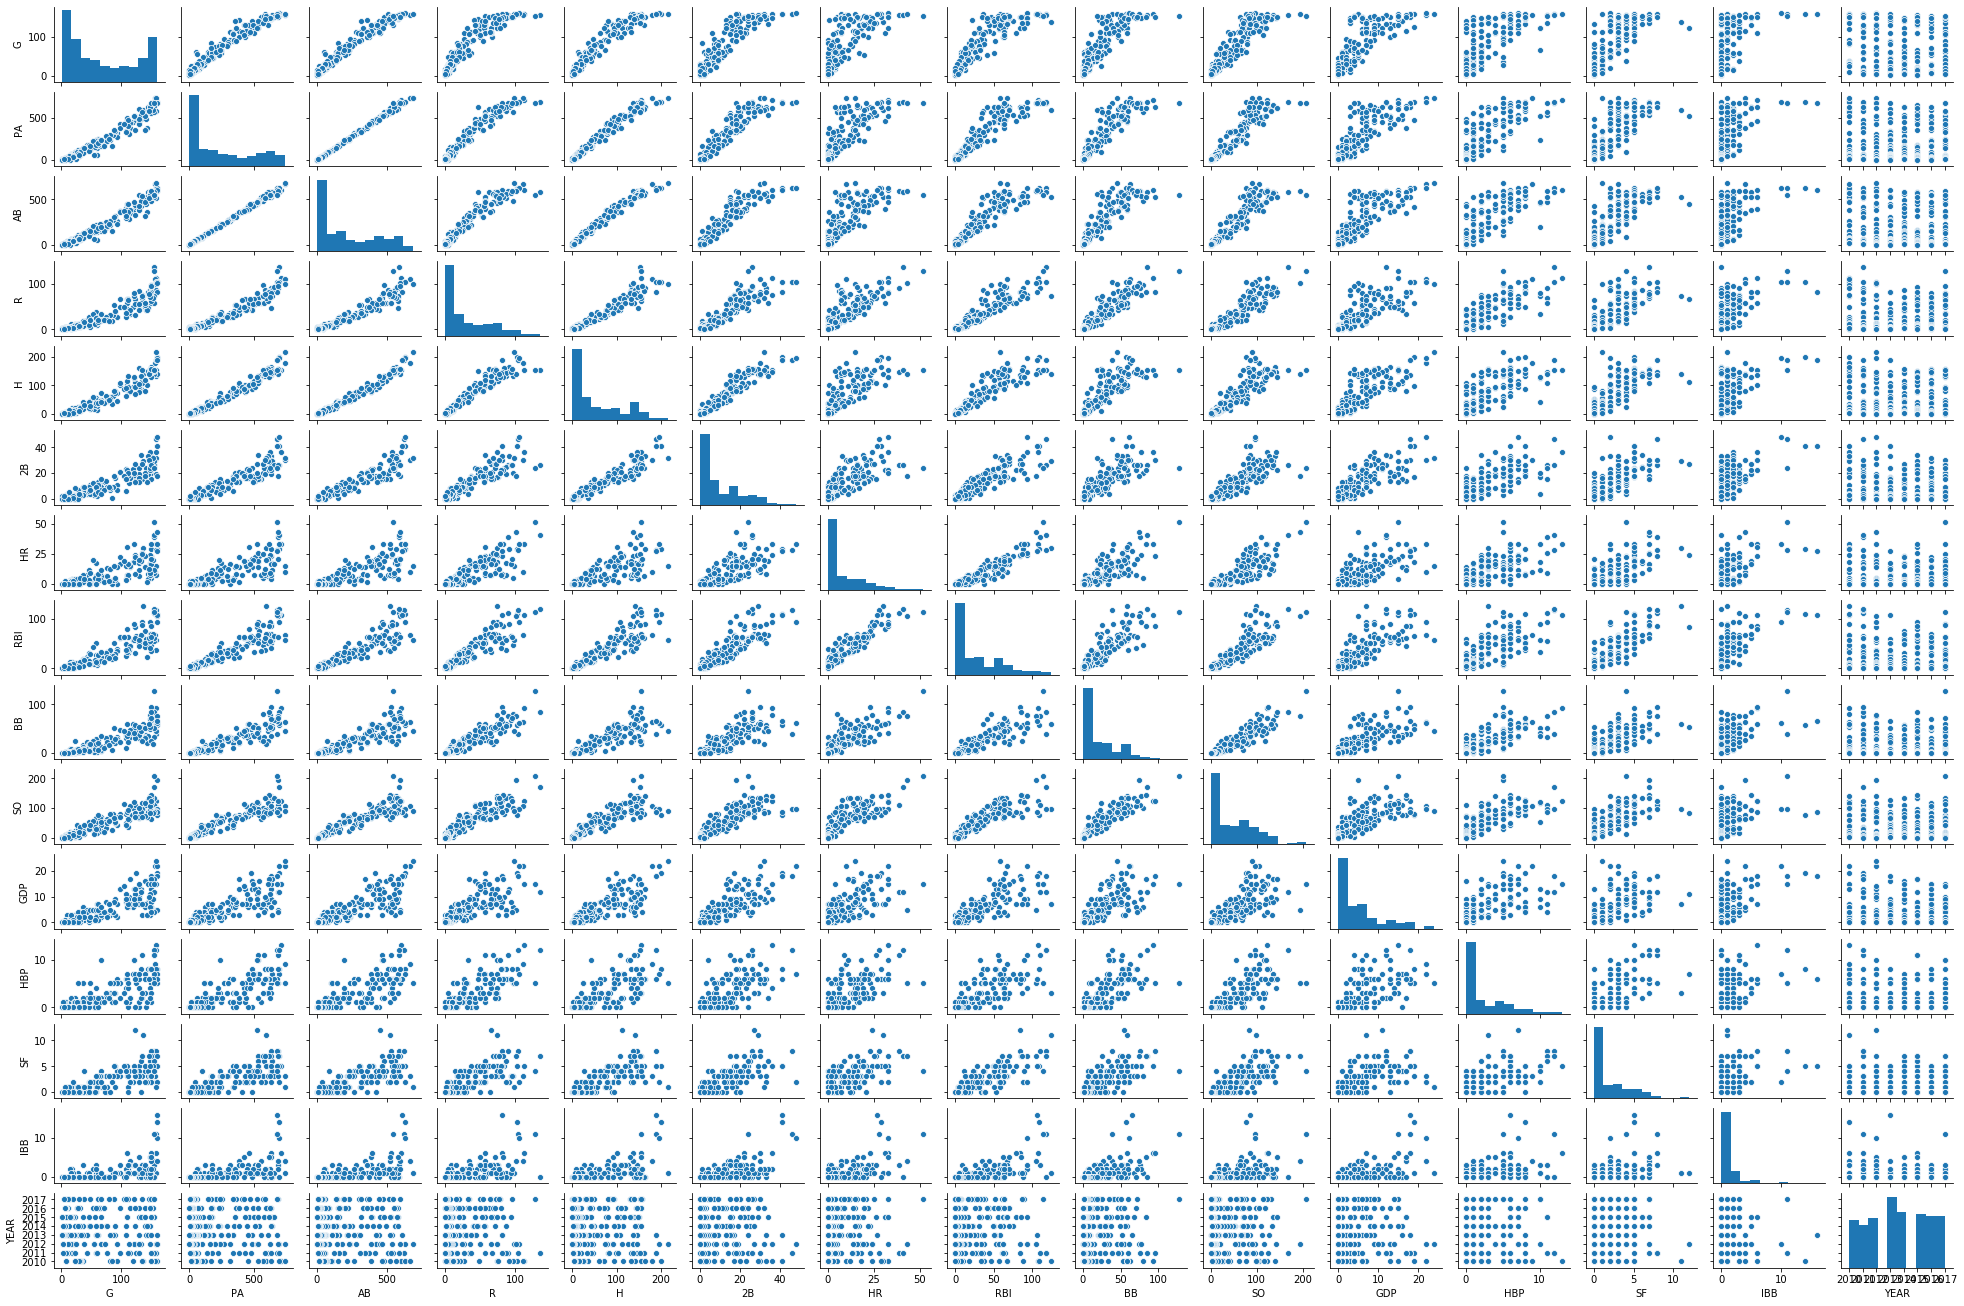

In [20]:
sns.pairplot(seasons_combined_train, height=1.2, aspect=1.5);

In [21]:
col_name = 'HR'
first_col = seasons_combined_train.pop(col_name)


In [22]:
seasons_combined_train.insert(2, col_name,first_col)


In [23]:
seasons_combined_train.head()

,Name,G,HR,PA,AB,R,H,2B,RBI,BB,SO,GDP,HBP,SF,IBB,YEAR
0,Francisco Cervelli,93,0,317,266,27,72,11,38,33,42,7,6,4,1,2010
1,Mark Teixeira#,158,33,712,601,113,154,36,108,93,122,15,13,5,6,2010
2,Robinson Cano*,160,29,696,626,103,200,41,109,57,77,19,8,5,14,2010
3,Derek Jeter,157,10,739,663,111,179,30,67,63,106,22,9,3,4,2010
4,Alex Rodriguez,137,30,595,522,74,141,29,125,59,98,7,3,11,1,2010


In [33]:
len(seasons_combined_train.sort_values(['Name','YEAR']).groupby(['Name']).HR.shift(-1))

197

In [42]:
seasons_combined_train = seasons_combined_train.sort_values(['Name','YEAR'])

In [43]:
seasons_combined_train['HR_PREDICT'] = seasons_combined_train.groupby(['Name']).HR.shift(-1).to_list()

In [64]:
seasons_combined_clean_test = seasons_combined_clean[seasons_combined_clean.YEAR>('2017')] # test 

In [44]:
seasons_combined_train[['Name','YEAR','HR','HR_PREDICT']]

,Name,YEAR,HR,HR_PREDICT
7,Aaron Hicks#,2016,8,15.0
10,Aaron Hicks#,2017,15,27.0
6,Aaron Hicks#,2018,27,12.0
12,Aaron Hicks#,2019,12,NaN
15,Aaron Judge,2016,4,52.0
...,...,...,...,...
5,Vernon Wells,2013,11,NaN
4,Yangervis Solarte#,2014,6,NaN
19,Zelous Wheeler,2014,2,NaN
17,Zoilo Almonte#,2013,1,1.0


In [57]:
seasons_combined_clean = seasons_combined_train.dropna()

In [ ]:
seasons_combined_clean_test = seasons_combined_clean[seasons_combined_clean.YEAR>('2017')]
# test 

In [46]:

y, X = patsy.dmatrices('HR_PREDICT ~ HR + G + AB + R + H  + RBI + BB + SO + GDP + SF + IBB', 
                       data=seasons_combined_train, return_type="dataframe")


model = sm.OLS(y, sm.add_constant(X))


fit = model.fit()


fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HR_PREDICT   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     5.180
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           1.89e-06
Time:                        13:26:56   Log-Likelihood:                -425.21
No. Observations:                 116   AIC:                             874.4
Df Residuals:                     104   BIC:                             907.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9439      1.992      3.485      0.001       2.993      10.895
HR             0.0233      0.339      0.069      0.945      -0.650       0.697
G             -0.1549      0.100     -1.543      0.126      -0.354       0.044
AB             0.0885      0.052      1.712      0.090      -0.014       0.191
R             -0.0331      0.141     -0.234      0.816      -0.314       0.248
H             -0.2203      0.146     -1.506      0.135      -0.510       0.070
RBI            0.3020      0.162      1.859      0.066      -0.020       0.624
BB             0.0898      0.110      0.818      0.415      -0.128       0.307
SO            -0.0220      0.064     -0.342      0.733      -0.150       0.106
GDP            0.0382      0.289      0.132      0.895      -0.536       0.612
SF            -1.3284      0.704     -1.886      0.062      -2.725       0.069
IBB            0.1382      0.585      0.236      0.814      -1.022       1.299
==============================================================================
Omnibus:                       32.996   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.326
Skew:                           1.163   Prob(JB):                     2.40e-15
Kurtosis:                       5.919   Cond. No.                         889.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the HR ~ G + AB ETC... model
X = seasons_combined_clean[['HR','G','AB','R','H','RBI','BB','SF','GDP','SF','IBB']]

# Choose the response variable(s)
y = seasons_combined_clean['HR_PREDICT']

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.36219478637012303

In [26]:
lr.coef_

array([-0.29028949,  0.28747226,  0.07473291, -0.07477431, -0.12672413,
        0.4064643 ,  0.27946736,  0.05748552, -0.04315449,  0.10553848,
       -0.42836985,  0.27407899,  0.20803055])

In [27]:
lr.intercept_

-419.2972497969099

In [ ]:
lr.predict()

In [ ]:
driver = webdriver.Chrome(chromedriver)
driver.get()

In [ ]:
driver.page_source[:1000]

In [ ]:
driver.quit()

In [ ]:

caldo_feo = BeautifulSoup(driver.page_source, 'html.parser')


In [ ]:
table = caldo_feo.body.find('table', id= 'team_batting').find('tbody')
table
rows = [row for row in table.find_all('tr')]
rows




#div_id_all_team_batting = body.find('div',id='all_team_batting')